In [1]:
import pandas as pd
from sklearn import tree


In [28]:
demographics_data = pd.read_csv("../Dataset/Demographics/demographics.csv")
sensing_data = pd.read_csv("../Dataset/Sensing/sensing.csv")
ema_data = pd.read_csv("../Dataset/EMA/general_ema.csv")
covid_ema_data = pd.read_csv("../Dataset/EMA/covid_ema.csv")

# Develop predictive modeling pipelines with customizable “features” and “outcomes”.

## Data Preprocessing Functions

In [3]:
def get_academic_quarter(day):
    """
    Convert YYYYMMDD to academic quarter (0-3)
    0: Fall (mid-Sept to late Nov)
    1: Winter (Jan to early Mar)
    2: Spring (late Mar to early June)
    3: Summer (mid-June to early Sept)
    """
    # Convert string date to datetime
    date = pd.to_datetime(str(day), format='%Y%m%d')
    month = date.month
    day = date.day
    
    if (month == 9 and day >= 15) or month == 10 or (month == 11 and day <= 30):
        return 0  # Fall
    elif month == 1 or month == 2 or (month == 3 and day <= 15):
        return 1  # Winter
    elif (month == 3 and day > 15) or month == 4 or month == 5 or (month == 6 and day <= 10):
        return 2  # Spring
    else:
        return 3  # Summer

In [31]:
# First, merge all three datasets into ONE DF
def prepare_merged_dataset(sensing_data, demographics_data, ema_data, covid_ema_data):
    """
    Merge sensing, demographics, and EMA data
    """
    # Merge sensing and demographics first
    sensing_data['formatted_day'] = pd.to_datetime(sensing_data['day'].astype(str), format='%Y%m%d')
    # Adds new column for day of the week
    sensing_data['day_of_week'] = sensing_data['formatted_day'].dt.day_name()
    merged = sensing_data.merge(
        demographics_data,
        on='uid',
        how='inner'
    )
    
    # Then merge with EMA data
    merged = merged.merge(
        ema_data,
        on=['uid', 'day'],
        how='inner'
    )
    merged = merged.merge(
        covid_ema_data,
        on=['uid', 'day'],
        how='inner'
    )
    
    # Add academic quarter
    merged['quarter'] = merged['day'].apply(get_academic_quarter)
    
    return merged

In [17]:
# Organized feature dictionary into categories and platforms
''' 
Categories: demographics, activity, location, phone, sleep, audio, calls, sms, light, steps, quality
Platforms: all, android, ios
'''
feature_dict = {
    'demographics': [
        'gender', 'race'
    ],
    
    'activity': {
        'all': [
            'act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0'
        ],
        'android': [
            'act_on_foot_ep_0', 'act_tilting_ep_0'
        ],
        'ios': [
            'act_running_ep_0', 'act_walking_ep_0'
        ]
    },
    
    'location': [
        'loc_dist_ep_0', 'loc_visit_num_ep_0', 'loc_max_dis_from_campus_ep_0',
        'loc_food_dur', 'loc_health_dur', 'loc_home_dur', 'loc_leisure_dur',
        'loc_other_dorm_dur', 'loc_self_dorm_dur', 'loc_social_dur', 
        'loc_study_dur', 'loc_workout_dur', 'loc_worship_dur'
    ],
    
    'phone': {
        'all': [
            'unlock_duration_ep_0', 'unlock_num_ep_0'
        ],
        'ios': [
            'other_playing_duration_ep_0', 'other_playing_num_ep_0'
        ]
    },
    
    'sleep': {
        'all': [
            'sleep_duration', 'sleep_start', 'sleep_end'
        ],
        'ios': [
            'sleep_heathkit_dur'
        ]
    },
    'audio': {
        'android': [
            'audio_amp_mean_ep_0', 'audio_amp_std_ep_0',
            'audio_convo_duration_ep_0', 'audio_convo_num_ep_0',
            'audio_voice_ep_0'
        ]
    },
    
    'calls': {
        'android': [
            'call_in_duration_ep_0', 'call_in_num_ep_0',
            'call_out_duration_ep_0', 'call_out_num_ep_0',
            'call_miss_num_ep_0'
        ]
    },
    
    'sms': {
        'android': [
            'sms_in_num_ep_0', 'sms_out_num_ep_0'
        ]
    },
    
    'light': {
        'android': [
            'light_mean_ep_0', 'light_std_ep_0'
        ]
    },
    
    'steps': {
        'ios': [
            'step_ep_0'
        ]
    },
    
    'quality': {
        'all': [
            'quality_activity', 'quality_loc'
        ],
        'android': [
            'quality_audio', 'quality_light'
        ]
    },
    'date': [
        'day_of_week', 'quarter'
    ]
}

## Predictive Model (Tree)

In [39]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import numpy as np

class PredictiveModel:
    def __init__(self, target_col, is_classification=True, platform='all', feature_set=None, feature_dict=None, feature_list=None):
        """
        Initialize model with platform specification
        platform: 'all', 'android', or 'ios'
        """
        self.feature_dict = feature_dict
        self.target_col = target_col
        self.is_classification = is_classification
        self.platform = platform
        self.feature_list = feature_list
        self.feature_set = feature_set
        self.label_encoders = {}
        # Imputers: used for numerical and categorical variables with missing values
        self.imputer = SimpleImputer(strategy='median') # Dummy value for numerical
        self.categorical_imputer = SimpleImputer(strategy='most_frequent') # Dummy value for categorical
        
        if is_classification:
            self.model = DecisionTreeClassifier(random_state=42)
        else:
            self.model = DecisionTreeRegressor(random_state=42)
    
    def preprocess_features(self, data):
        """Preprocess features including handling missing values"""
        X = data.copy()
        categorical_cols = ['gender', 'race', 'day_of_week']
        numerical_cols = [col for col in X.columns if col not in categorical_cols]
        # Handle categorical variables with LabelEncoder (convert to numerical)
        for col in categorical_cols:
            if col in X.columns:
                X[col] = self.categorical_imputer.fit_transform(X[[col]]) # impute missing values
                # Encode
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                    X[col] = self.label_encoders[col].fit_transform(X[col].astype(str))
                else:
                    X[col] = self.label_encoders[col].transform(X[col].astype(str))
        
        X[numerical_cols] = self.imputer.fit_transform(X[numerical_cols]) # Encode missing values
        return X
    
    def get_platform_features(self, data):
        """Get features based on platform selection and feature sets"""
        # noramlize data
        selected_features = []
        if self.feature_list is not None:
            return self.feature_list
        # If no feature sets specified, use all available
        if self.feature_set is None:
            self.feature_set = self.feature_dict.keys()
        
        # Adding features based on selected categories
        for category in self.feature_set:
            if category in self.feature_dict:
                if isinstance(self.feature_dict[category], dict): # Features with platform-specific categories
                    if 'all' in self.feature_dict[category]:
                        selected_features.extend(self.feature_dict[category]['all'])
                    if self.platform in self.feature_dict[category]: # IOS or Android
                        selected_features.extend(self.feature_dict[category][self.platform])
                else:
                    selected_features.extend(self.feature_dict[category])
                    # If not dictionary, then it's shared across platforms
        # Always include is_ios for platform identification
        if 'is_ios' not in selected_features:
            selected_features.append('is_ios')
        return [f for f in selected_features if f in data.columns] # Return only features that exist in the dataset
    
    def train_evaluate(self, merged_data):
        """Train and evaluate the model using 80/20 train-test split"""
        # ============================ DATA PREPROCESSING ============================
        # Filter based on platform
        if self.platform == 'android':
            merged_data = merged_data[merged_data['is_ios'] == 0] # Android
        elif self.platform == 'ios':
            merged_data = merged_data[merged_data['is_ios'] == 1] # iOS
            
        # Drop NaN values in target column
        merged_data = merged_data.dropna(subset=[self.target_col])
        
        # Get features available in the dataset based on platform and feature set
        features = self.get_platform_features(merged_data)
        
        # Prepare features
        X = self.preprocess_features(merged_data[features])
        y = merged_data[self.target_col]
        
        # Split the data 80/20
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, 
            test_size=0.2, 
            random_state=42
        )
        
        # Print data shapes and missing value info
        print(f"\nTraining data shape: {X_train.shape}")
        print(f"Testing data shape: {X_test.shape}")
        print(f"Number of features used: {len(features)}")
        
        # ============================ TRAINING MODEL ============================
        self.model.fit(X_train, y_train)
        
        # ============================ EVALUATING MODEL ============================
        y_pred = self.model.predict(X_test)
        
        # Calculate metrics
        if self.is_classification:
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            return {
                'accuracy': accuracy,
                'f1_score': f1,
                'n_train': len(X_train),
                'n_test': len(X_test),
                'features_used': features,
                'feature_importance': pd.DataFrame({
                    'feature': features,
                    'importance': self.model.feature_importances_
                }).sort_values('importance', ascending=False)
            }
        else:
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            return {
                'mse': mse,
                'rmse': rmse,
                'n_train': len(X_train),
                'n_test': len(X_test),
                'features_used': features,
                'feature_importance': pd.DataFrame({
                    'feature': features,
                    'importance': self.model.feature_importances_
                }).sort_values('importance', ascending=False)
            }

# Feature Exploration

In [35]:
def run_predictions(merged_data, platform='all', feature_set=None, feature_list=None):
    """
    Run predictions for different target variables
    """
    prediction_tasks = [
        {
            'col': 'stress',
            'is_classification': True,
            'description': 'Current stress level (1-5)'
        },
        {
            'col': 'social_level',
            'is_classification': True,
            'description': 'Social interaction level (1-5)'
        },
        {
            'col': 'phq4_score',
            'is_classification': False,
            'description': 'PHQ4 depression/anxiety score (0-12)'
        },
        {
            'col': 'phq4-1',
            'is_classification': True,
            'description': 'PHQ4 depression/anxiety score (0-12)'
        },
        {
            'col': 'phq4-2',
            'is_classification': True,
            'description': 'PHQ4 depression/anxiety score (0-12)'
        },
        {
            'col': 'phq4-3',
            'is_classification': True,
            'description': 'PHQ4 depression/anxiety score (0-12)'
        },
        {
            'col': 'phq4-4',
            'is_classification': True,
            'description': 'PHQ4 depression/anxiety score (0-12)'
        },
        {
            'col': 'pam',
            'is_classification': True,
            'description': 'Photographic Affect Meter score (1-16)'
        },
        {
            'col': 'sse3-1',
            'is_classification': True,
            'description': 'Self-Esteem score (1-100)'
        },
        {
            'col': 'sse3-2',
            'is_classification': True,
            'description': 'Self-Esteem score (1-100)'
        },
        {
            'col': 'sse3-3',
            'is_classification': True,
            'description': 'Self-Esteem score (1-100)'
        },
        {
            'col': 'sse3-4',
            'is_classification': True,
            'description': 'Self-Esteem score (1-100)'
        },
        {
            'col': 'COVID-1',
            'is_classification': True,
            'description': 'COVID-19 related anxiety score (1-5)'
        },
        {
            'col': 'COVID-2',
            'is_classification': True,
            'description': 'COVID-19 related anxiety score (1-5)'
        },
        {
            'col': 'COVID-3',
            'is_classification': True,
            'description': 'COVID-19 related anxiety score (1-5)'
        },
        {
            'col': 'COVID-4',
            'is_classification': True,
            'description': 'COVID-19 related anxiety score (1-5)'
        },
        {
            'col': 'COVID-5',
            'is_classification': True,
            'description': 'COVID-19 related anxiety score (1-5)'
        }, 
        {
            'col': 'COVID-6',
            'is_classification': True,
            'description': 'COVID-19 related anxiety score (1-5)'
        },
        {
            'col': 'COVID-7',
            'is_classification': True,
            'description': 'COVID-19 related anxiety score (1-5)'
        },
        {
            'col': 'COVID-8',
            'is_classification': True,
            'description': 'COVID-19 related anxiety score (1-5)'
        },
        {
            'col': 'COVID-9',
            'is_classification': True,
            'description': 'COVID-19 related anxiety score (1-5)'
        },
        {
            'col': 'COVID-10',
            'is_classification': True,
            'description': 'COVID-19 related anxiety score (1-5)'
        }
    ]
    
    results = {}
    for task in prediction_tasks:
        print(f"\n{'='*50}")
        print(f"Analyzing {task['description']}")
        print(f"{'='*50}")
        
        # Create and train model
        model = PredictiveModel(
            target_col=task['col'],
            is_classification=task['is_classification'],
            platform=platform,
            feature_set=feature_set,
            feature_dict=feature_dict,
            feature_list=feature_list
        )
        
        # Get predictions and metrics
        metrics = model.train_evaluate(
            merged_data
        )
        
        # Store all metrics in results
        results[task['col']] = {
            'metrics': metrics,
            'features_used': model.get_platform_features(merged_data)
        }

        
        # Print current results
        print(f"\nResults for {task['col']}:")
        print("-" * 30)
        
        # Print metrics
        for metric, value in metrics.items():
            print(f"{metric}: {value}")

        
    return results

def print_results(results, description):
    """Print results in a formatted way"""
    print(f"\nResults for {description}")
    print("=" * 50)
    
    for target, result in results.items():
        print(f"\nTarget: {target}")
        print("-" * 30)
        
        # Print metrics
        if 'metrics' in result:
            for metric, value in result['metrics'].items():
                print(f"{metric}: {value}")
        
        # Print features used
        if 'features_used' in result:
            print(f"features_used: {result['features_used']}")
        
        # Print feature importance
        if 'feature_importance' in result:
            print("\nTop Features:")
            print(result['feature_importance'].head(3))

In [61]:
merged_data = prepare_merged_dataset(sensing_data, demographics_data, ema_data, covid_ema_data)

# Run predictions
results = run_predictions(
    merged_data=merged_data,
    platform='all',
    feature_list=['loc_max_dis_from_campus_ep_0', 'act_in_vehicle_ep_0', 'quarter', 'act_still_ep_0']

print_results(results, "Important features for stress")


Analyzing Current stress level (1-5)

Training data shape: (10216, 4)
Testing data shape: (2555, 4)
Number of features used: 4

Results for stress:
------------------------------
accuracy: 0.3201565557729941
f1_score: 0.3217949219411468
n_train: 10216
n_test: 2555
features_used: ['loc_max_dis_from_campus_ep_0', 'act_in_vehicle_ep_0', 'quarter', 'act_still_ep_0']
feature_importance:                         feature  importance
3                act_still_ep_0    0.419283
0  loc_max_dis_from_campus_ep_0    0.332424
1           act_in_vehicle_ep_0    0.220812
2                       quarter    0.027482

Analyzing Social interaction level (1-5)

Training data shape: (10216, 4)
Testing data shape: (2555, 4)
Number of features used: 4

Results for social_level:
------------------------------
accuracy: 0.30802348336594915
f1_score: 0.30718797613190185
n_train: 10216
n_test: 2555
features_used: ['loc_max_dis_from_campus_ep_0', 'act_in_vehicle_ep_0', 'quarter', 'act_still_ep_0']
feature_importan

In [63]:
merged_data = prepare_merged_dataset(sensing_data, demographics_data, ema_data, covid_ema_data)

# Run predictions
results = run_predictions(
    merged_data=merged_data,
    platform='all',
    feature_list=['race', 'act_in_vehicle_ep_0']

print_results(results, "Important features for social level")


Analyzing Current stress level (1-5)

Training data shape: (10216, 2)
Testing data shape: (2555, 2)
Number of features used: 2

Results for stress:
------------------------------
accuracy: 0.2974559686888454
f1_score: 0.2803082474280362
n_train: 10216
n_test: 2555
features_used: ['race', 'act_in_vehicle_ep_0']
feature_importance:                feature  importance
1  act_in_vehicle_ep_0    0.956751
0                 race    0.043249

Analyzing Social interaction level (1-5)

Training data shape: (10216, 2)
Testing data shape: (2555, 2)
Number of features used: 2

Results for social_level:
------------------------------
accuracy: 0.2594911937377691
f1_score: 0.2512553765311668
n_train: 10216
n_test: 2555
features_used: ['race', 'act_in_vehicle_ep_0']
feature_importance:                feature  importance
1  act_in_vehicle_ep_0    0.945316
0                 race    0.054684

Analyzing PHQ4 depression/anxiety score (0-12)

Training data shape: (10216, 2)
Testing data shape: (2555, 2)
Num

In [65]:
merged_data = prepare_merged_dataset(sensing_data, demographics_data, ema_data, covid_ema_data)

# Run predictions
results = run_predictions(
    merged_data=merged_data,
    platform='all',
    feature_list=['loc_dist_ep_0', 'loc_home_dur', 'race']
)

print_results(results, "Important features for social_level score")


Analyzing Current stress level (1-5)

Training data shape: (10216, 3)
Testing data shape: (2555, 3)
Number of features used: 3

Results for stress:
------------------------------
accuracy: 0.3232876712328767
f1_score: 0.30899702369578597
n_train: 10216
n_test: 2555
features_used: ['loc_dist_ep_0', 'loc_home_dur', 'race']
feature_importance:          feature  importance
0  loc_dist_ep_0    0.558537
1   loc_home_dur    0.415030
2           race    0.026433

Analyzing Social interaction level (1-5)

Training data shape: (10216, 3)
Testing data shape: (2555, 3)
Number of features used: 3

Results for social_level:
------------------------------
accuracy: 0.27045009784735813
f1_score: 0.262375204574706
n_train: 10216
n_test: 2555
features_used: ['loc_dist_ep_0', 'loc_home_dur', 'race']
feature_importance:          feature  importance
0  loc_dist_ep_0    0.520584
1   loc_home_dur    0.430128
2           race    0.049288

Analyzing PHQ4 depression/anxiety score (0-12)

Training data shape: (

In [64]:
merged_data = prepare_merged_dataset(sensing_data, demographics_data, ema_data, covid_ema_data)

# Run predictions
results = run_predictions(
    merged_data=merged_data,
    platform='all',
    feature_list=['race', 'loc_max_dis_from_campus_ep_0', 'sleep_duration']
)

print_results(results, "Important features for PHQ4 score")


Analyzing Current stress level (1-5)

Training data shape: (10216, 3)
Testing data shape: (2555, 3)
Number of features used: 3

Results for stress:
------------------------------
accuracy: 0.36086105675146773
f1_score: 0.354977527183802
n_train: 10216
n_test: 2555
features_used: ['race', 'loc_max_dis_from_campus_ep_0', 'sleep_duration']
feature_importance:                         feature  importance
1  loc_max_dis_from_campus_ep_0    0.688660
2                sleep_duration    0.271273
0                          race    0.040067

Analyzing Social interaction level (1-5)

Training data shape: (10216, 3)
Testing data shape: (2555, 3)
Number of features used: 3

Results for social_level:
------------------------------
accuracy: 0.324853228962818
f1_score: 0.32115169457348564
n_train: 10216
n_test: 2555
features_used: ['race', 'loc_max_dis_from_campus_ep_0', 'sleep_duration']
feature_importance:                         feature  importance
1  loc_max_dis_from_campus_ep_0    0.638162
2     

In [40]:
merged_data = prepare_merged_dataset(sensing_data, demographics_data, ema_data, covid_ema_data)

# Run predictions
results = run_predictions(
    merged_data=merged_data,
    platform='all',
    feature_set=['demographics', 'activity', 'location', 'phone', 'sleep', 'audio', 'calls', 'sms', 'light', 'steps', 'quality', 'date']
)

print_results(results, "All Platforms - Activity and Sleep")


Analyzing Current stress level (1-5)

Training data shape: (10216, 38)
Testing data shape: (2555, 38)
Number of features used: 38

Results for stress:
------------------------------
accuracy: 0.3232876712328767
f1_score: 0.32447286795038804
n_train: 10216
n_test: 2555
features_used: ['gender', 'race', 'act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'loc_dist_ep_0', 'loc_visit_num_ep_0', 'loc_max_dis_from_campus_ep_0', 'loc_food_dur', 'loc_health_dur', 'loc_home_dur', 'loc_leisure_dur', 'loc_other_dorm_dur', 'loc_self_dorm_dur', 'loc_social_dur', 'loc_study_dur', 'loc_workout_dur', 'loc_worship_dur', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'sleep_duration', 'sleep_start', 'sleep_end', 'sleep_duration', 'sleep_start', 'sleep_end', 'quality_activity', 'quality_loc', 'quality_activity', 'quality_loc', 'day_of_week', 'quarter', 'is_ios']
feature_importance:               


Analyzing features for stress

Number of features selected: 33

Categorical features: ['gender', 'race', 'day_of_week']
Numeric features: ['act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'sleep_duration', 'sleep_start', 'sleep_end', 'sleep_duration', 'sleep_start', 'sleep_end', 'loc_dist_ep_0', 'loc_visit_num_ep_0', 'loc_max_dis_from_campus_ep_0', 'loc_food_dur', 'loc_health_dur', 'loc_home_dur', 'loc_leisure_dur', 'loc_other_dorm_dur', 'loc_self_dorm_dur', 'loc_social_dur', 'loc_study_dur', 'loc_workout_dur', 'loc_worship_dur', 'quarter']


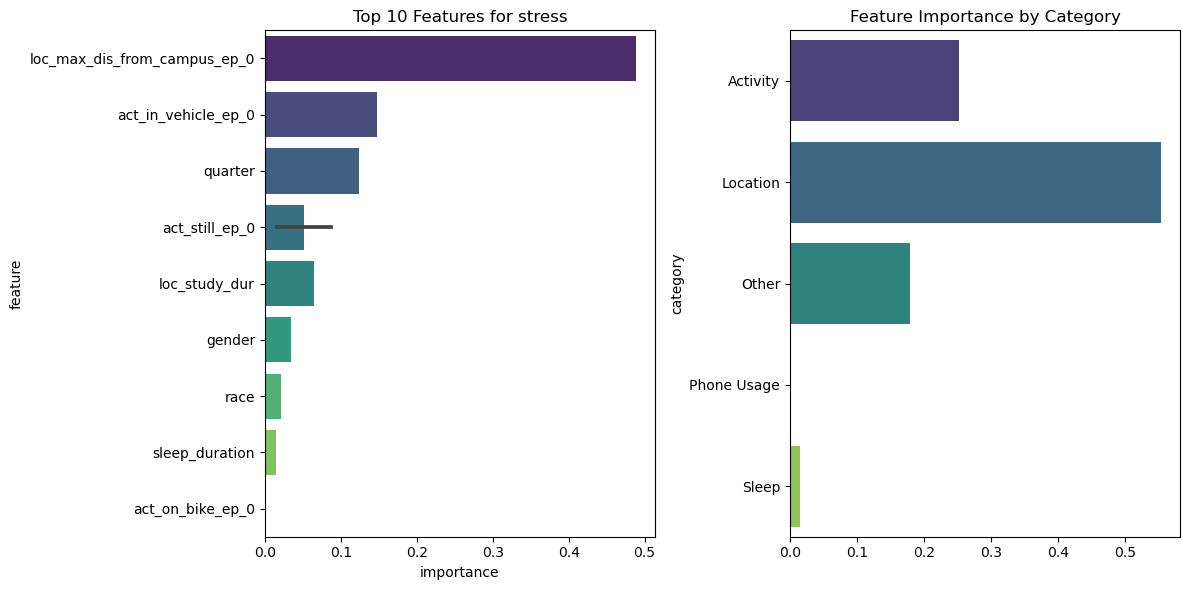


Training data shape: (35126, 33)
Number of features used: 33

Top 10 Most Important Features:
loc_max_dis_from_campus_ep_0: 0.4889 (Location)
act_in_vehicle_ep_0: 0.1478 (Activity)
quarter: 0.1234 (Other)
act_still_ep_0: 0.0871 (Activity)
loc_study_dur: 0.0647 (Location)
gender: 0.0349 (Other)
race: 0.0214 (Other)
act_still_ep_0: 0.0165 (Activity)
sleep_duration: 0.0152 (Sleep)
act_on_bike_ep_0: 0.0000 (Activity)

Importance by Category:
Activity: 0.2514
Location: 0.5537
Other: 0.1797
Phone Usage: 0.0000
Sleep: 0.0152

Analyzing features for social_level

Number of features selected: 33

Categorical features: ['gender', 'race', 'day_of_week']
Numeric features: ['act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'sleep_duration', 'sleep_start', 'sleep_end', 'sleep_duration', 'sleep_start', 'sleep_end', 'loc_dist_ep_0', 'loc_visit_n

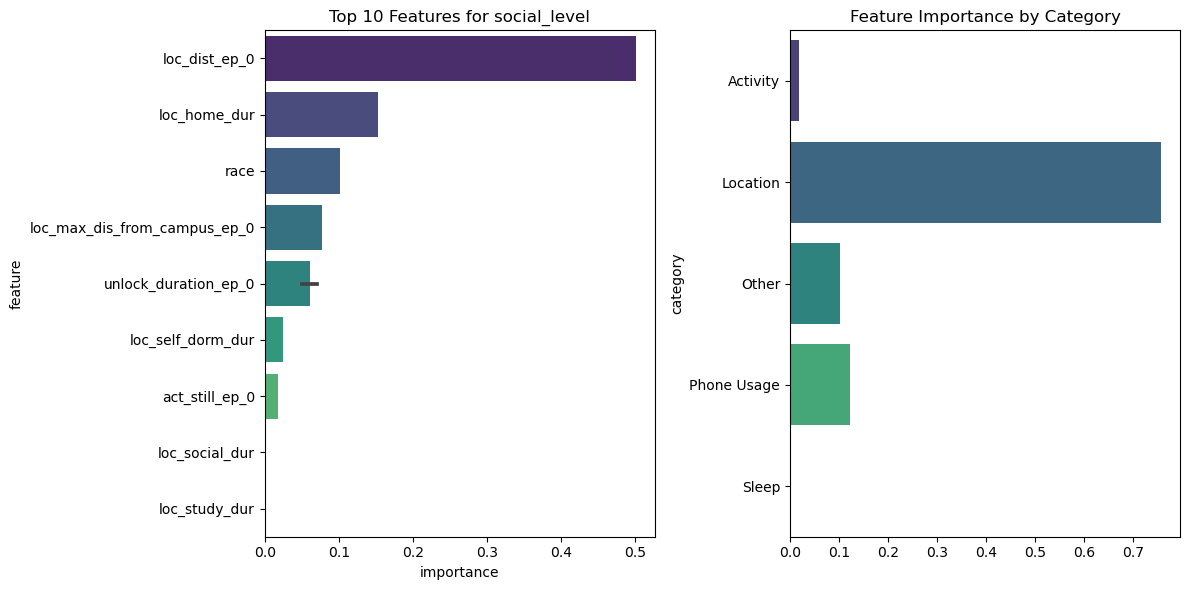


Training data shape: (35126, 33)
Number of features used: 33

Top 10 Most Important Features:
loc_dist_ep_0: 0.5021 (Location)
loc_home_dur: 0.1525 (Location)
race: 0.1023 (Other)
loc_max_dis_from_campus_ep_0: 0.0778 (Location)
unlock_duration_ep_0: 0.0711 (Phone Usage)
unlock_duration_ep_0: 0.0509 (Phone Usage)
loc_self_dorm_dur: 0.0248 (Location)
act_still_ep_0: 0.0185 (Activity)
loc_social_dur: 0.0000 (Location)
loc_study_dur: 0.0000 (Location)

Importance by Category:
Activity: 0.0185
Location: 0.7572
Other: 0.1023
Phone Usage: 0.1220
Sleep: 0.0000

Analyzing features for phq4_score

Number of features selected: 33

Categorical features: ['gender', 'race', 'day_of_week']
Numeric features: ['act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'sleep_duration', 'sleep_start', 'sleep_end', 'sleep_duration', 'sleep_start', 'sleep_en

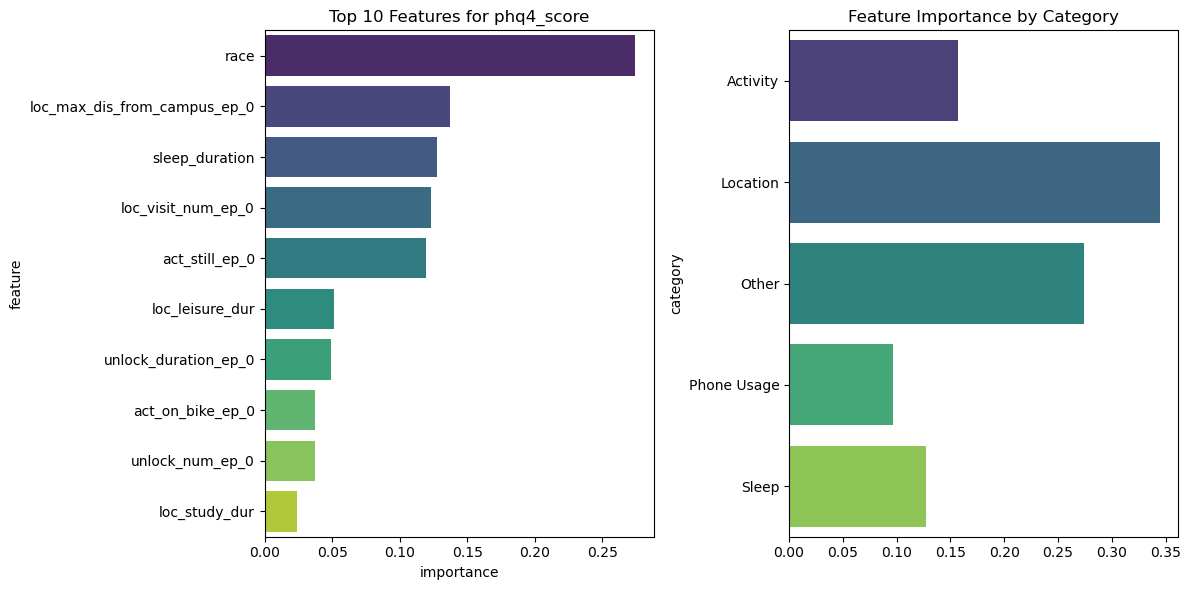


Training data shape: (35126, 33)
Number of features used: 33

Top 10 Most Important Features:
race: 0.2745 (Other)
loc_max_dis_from_campus_ep_0: 0.1370 (Location)
sleep_duration: 0.1277 (Sleep)
loc_visit_num_ep_0: 0.1228 (Location)
act_still_ep_0: 0.1195 (Activity)
loc_leisure_dur: 0.0510 (Location)
unlock_duration_ep_0: 0.0489 (Phone Usage)
act_on_bike_ep_0: 0.0375 (Activity)
unlock_num_ep_0: 0.0371 (Phone Usage)
loc_study_dur: 0.0239 (Location)

Importance by Category:
Activity: 0.1570
Location: 0.3445
Other: 0.2745
Phone Usage: 0.0962
Sleep: 0.1277

Analyzing features for pam

Number of features selected: 33

Categorical features: ['gender', 'race', 'day_of_week']
Numeric features: ['act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'sleep_duration', 'sleep_start', 'sleep_end', 'sleep_duration', 'sleep_start', 'sleep_end', 'loc

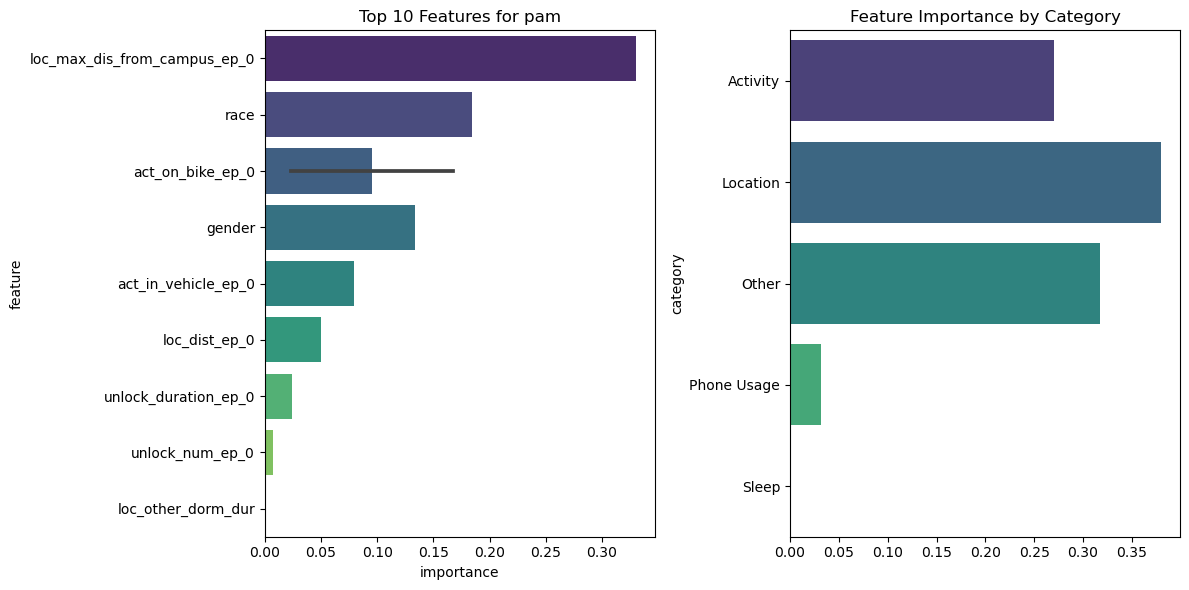


Training data shape: (34964, 33)
Number of features used: 33

Top 10 Most Important Features:
loc_max_dis_from_campus_ep_0: 0.3304 (Location)
race: 0.1843 (Other)
act_on_bike_ep_0: 0.1670 (Activity)
gender: 0.1334 (Other)
act_in_vehicle_ep_0: 0.0797 (Activity)
loc_dist_ep_0: 0.0497 (Location)
unlock_duration_ep_0: 0.0246 (Phone Usage)
act_on_bike_ep_0: 0.0234 (Activity)
unlock_num_ep_0: 0.0074 (Phone Usage)
loc_other_dorm_dur: 0.0000 (Location)

Importance by Category:
Activity: 0.2701
Location: 0.3801
Other: 0.3177
Phone Usage: 0.0320
Sleep: 0.0000

Analyzing features for stress

Number of features selected: 33

Categorical features: ['gender', 'race', 'day_of_week']
Numeric features: ['act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'sleep_duration', 'sleep_start', 'sleep_end', 'sleep_duration', 'sleep_start', 'sleep_end', 'lo

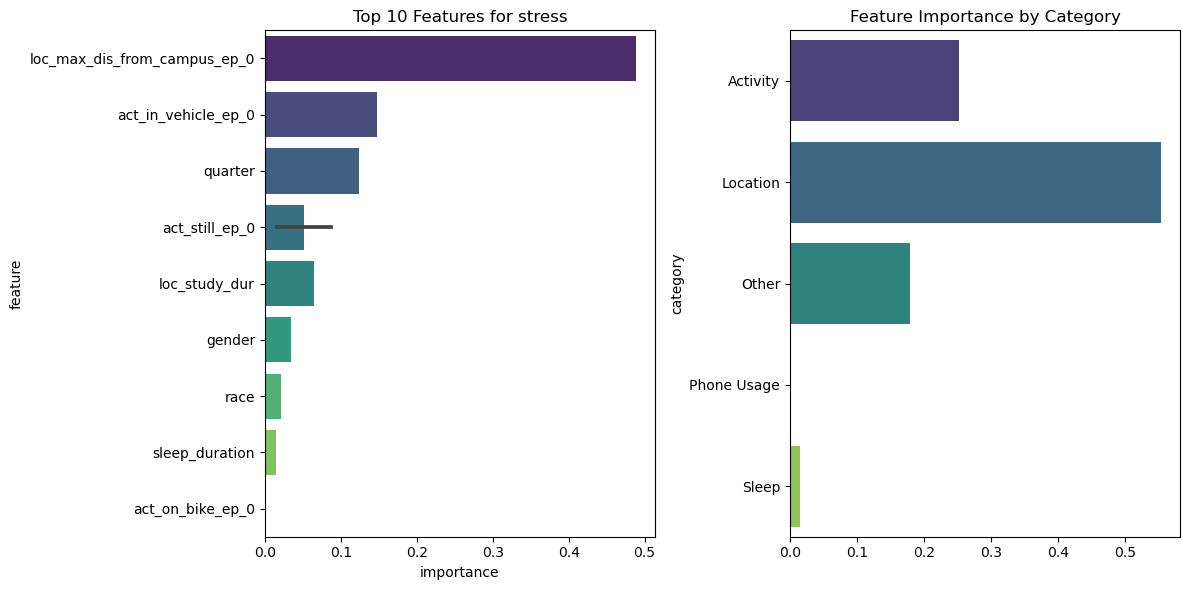


Training data shape: (35126, 33)
Number of features used: 33

Top 10 Most Important Features:
loc_max_dis_from_campus_ep_0: 0.4889 (Location)
act_in_vehicle_ep_0: 0.1478 (Activity)
quarter: 0.1234 (Other)
act_still_ep_0: 0.0871 (Activity)
loc_study_dur: 0.0647 (Location)
gender: 0.0349 (Other)
race: 0.0214 (Other)
act_still_ep_0: 0.0165 (Activity)
sleep_duration: 0.0152 (Sleep)
act_on_bike_ep_0: 0.0000 (Activity)

Importance by Category:
Activity: 0.2514
Location: 0.5537
Other: 0.1797
Phone Usage: 0.0000
Sleep: 0.0152

Analyzing features for social_level

Number of features selected: 33

Categorical features: ['gender', 'race', 'day_of_week']
Numeric features: ['act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'sleep_duration', 'sleep_start', 'sleep_end', 'sleep_duration', 'sleep_start', 'sleep_end', 'loc_dist_ep_0', 'loc_visit_n

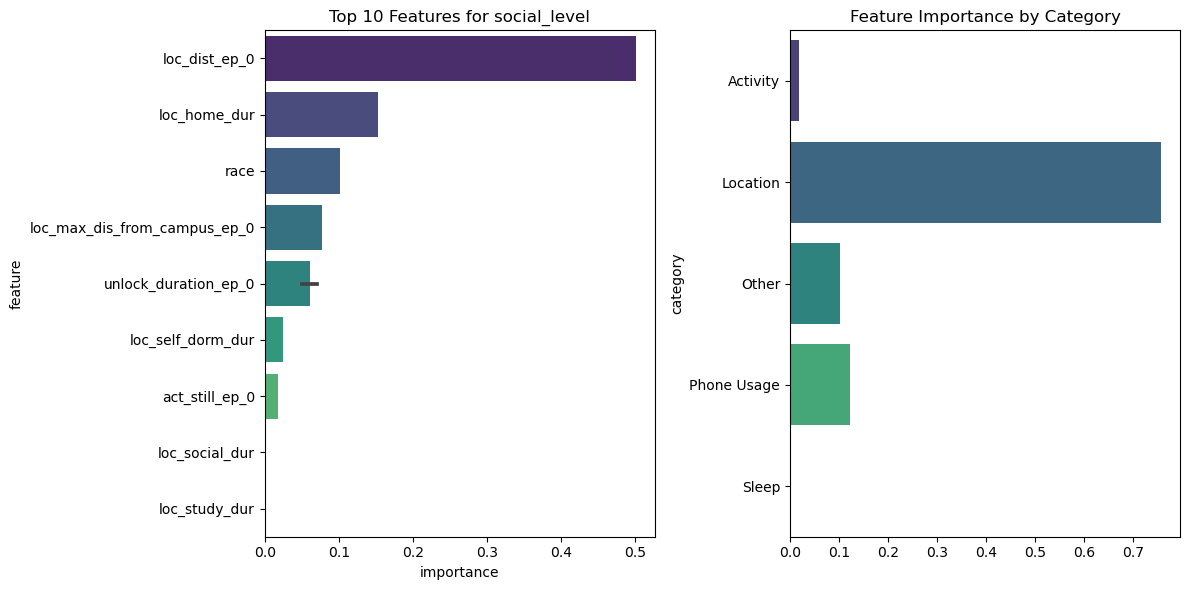


Training data shape: (35126, 33)
Number of features used: 33

Top 10 Most Important Features:
loc_dist_ep_0: 0.5021 (Location)
loc_home_dur: 0.1525 (Location)
race: 0.1023 (Other)
loc_max_dis_from_campus_ep_0: 0.0778 (Location)
unlock_duration_ep_0: 0.0711 (Phone Usage)
unlock_duration_ep_0: 0.0509 (Phone Usage)
loc_self_dorm_dur: 0.0248 (Location)
act_still_ep_0: 0.0185 (Activity)
loc_social_dur: 0.0000 (Location)
loc_study_dur: 0.0000 (Location)

Importance by Category:
Activity: 0.0185
Location: 0.7572
Other: 0.1023
Phone Usage: 0.1220
Sleep: 0.0000

Analyzing features for phq4_score

Number of features selected: 33

Categorical features: ['gender', 'race', 'day_of_week']
Numeric features: ['act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'sleep_duration', 'sleep_start', 'sleep_end', 'sleep_duration', 'sleep_start', 'sleep_en

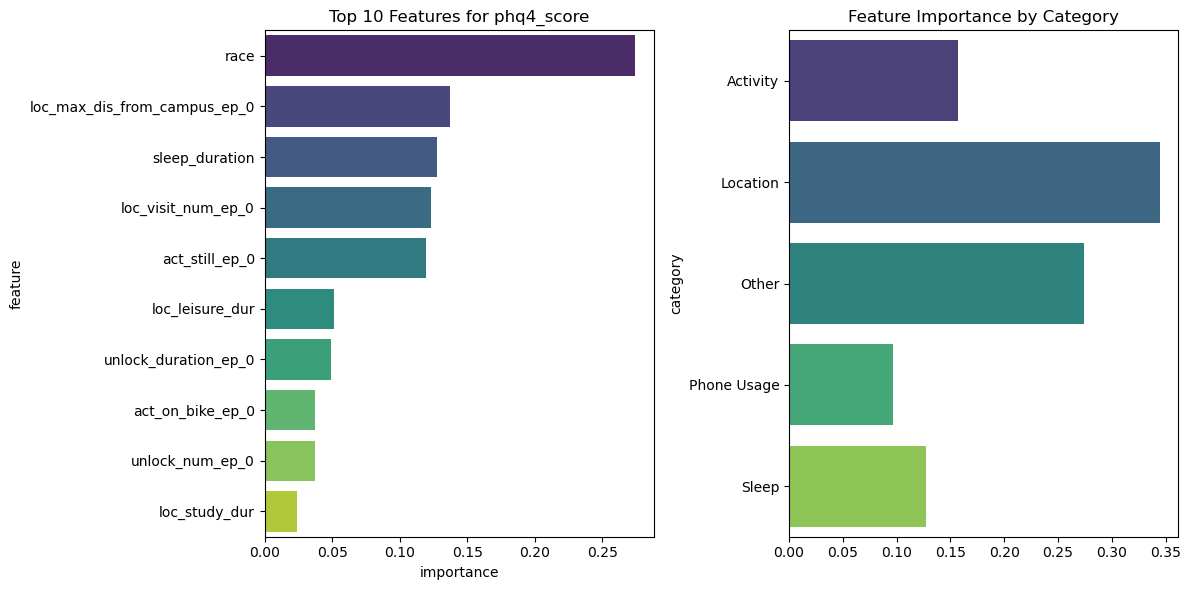


Training data shape: (35126, 33)
Number of features used: 33

Top 10 Most Important Features:
race: 0.2745 (Other)
loc_max_dis_from_campus_ep_0: 0.1370 (Location)
sleep_duration: 0.1277 (Sleep)
loc_visit_num_ep_0: 0.1228 (Location)
act_still_ep_0: 0.1195 (Activity)
loc_leisure_dur: 0.0510 (Location)
unlock_duration_ep_0: 0.0489 (Phone Usage)
act_on_bike_ep_0: 0.0375 (Activity)
unlock_num_ep_0: 0.0371 (Phone Usage)
loc_study_dur: 0.0239 (Location)

Importance by Category:
Activity: 0.1570
Location: 0.3445
Other: 0.2745
Phone Usage: 0.0962
Sleep: 0.1277

Analyzing features for pam

Number of features selected: 33

Categorical features: ['gender', 'race', 'day_of_week']
Numeric features: ['act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'unlock_duration_ep_0', 'unlock_num_ep_0', 'sleep_duration', 'sleep_start', 'sleep_end', 'sleep_duration', 'sleep_start', 'sleep_end', 'loc

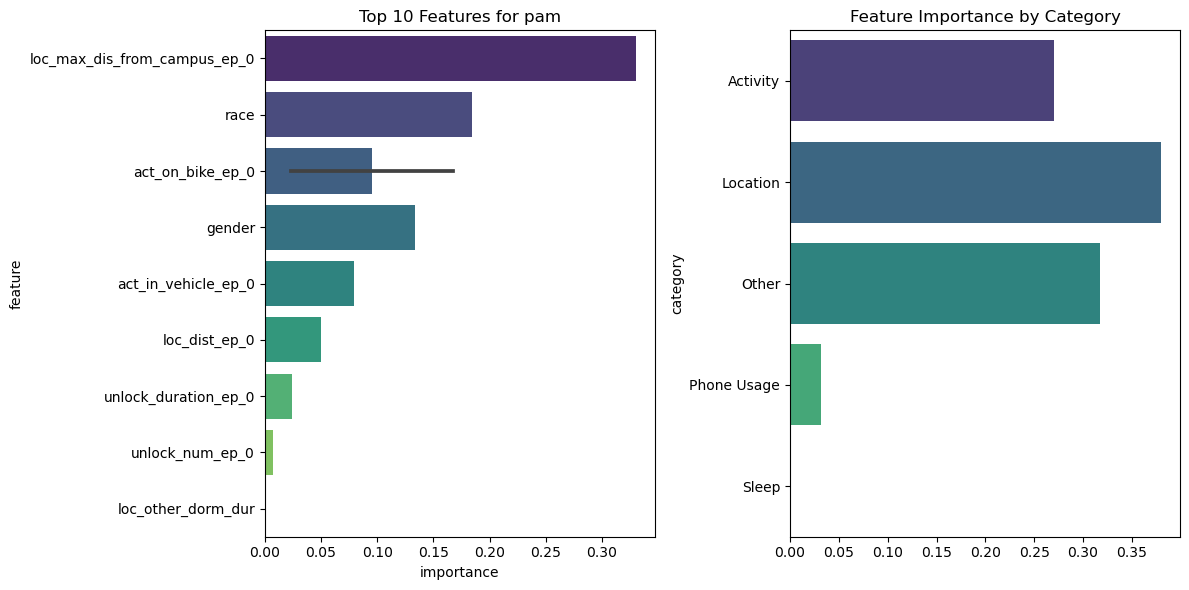


Training data shape: (34964, 33)
Number of features used: 33

Top 10 Most Important Features:
loc_max_dis_from_campus_ep_0: 0.3304 (Location)
race: 0.1843 (Other)
act_on_bike_ep_0: 0.1670 (Activity)
gender: 0.1334 (Other)
act_in_vehicle_ep_0: 0.0797 (Activity)
loc_dist_ep_0: 0.0497 (Location)
unlock_duration_ep_0: 0.0246 (Phone Usage)
act_on_bike_ep_0: 0.0234 (Activity)
unlock_num_ep_0: 0.0074 (Phone Usage)
loc_other_dorm_dur: 0.0000 (Location)

Importance by Category:
Activity: 0.2701
Location: 0.3801
Other: 0.3177
Phone Usage: 0.0320
Sleep: 0.0000


In [27]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_platform_features(data, platform='all'):
    """
    Get features based on platform and feature dictionary
    """
    features = []
    for category in ['activity', 'phone', 'sleep', 'audio']:
        if isinstance(feature_dict[category], dict):
            # Add common features for all platforms
            if 'all' in feature_dict[category]:
                features.extend(feature_dict[category]['all'])
            if platform in feature_dict[category]:
                features.extend(feature_dict[category][platform])
        else:
            features.extend(feature_dict[category])
    features.extend(feature_dict['location'])
    features.extend(feature_dict['quality'])
    features.extend(feature_dict['date'])
    features.extend(feature_dict['demographics'])

    return [f for f in features if f in data.columns]

def analyze_feature_importance(data, target_col, platform='all', is_classification=True, max_depth=4):
    """
    Analyze feature importance using decision trees
    """
    # Filter platform if needed
    if platform == 'android':
        data = data[data['is_ios'] == 0].copy()
    elif platform == 'ios':
        data = data[data['is_ios'] == 1].copy()
    else:
        data = data.copy()
    
    # Remove rows where target is NaN
    data = data.dropna(subset=[target_col])
    
    # Get features based on platform
    feature_cols = get_platform_features(data, platform)
    print(f"\nNumber of features selected: {len(feature_cols)}")
    
    # Get feature columns
    X = data[feature_cols].copy()  # Create a copy to avoid SettingWithCopyWarning
    y = data[target_col]
    
    # Handle categorical variables
    categorical_features = X.select_dtypes(include=['object']).columns
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    
    # Print feature types for debugging
    print("\nCategorical features:", list(categorical_features))
    print("Numeric features:", list(numeric_features))
    
    # Handle categorical variables
    for col in categorical_features:
        # Convert to numeric using label encoding
        X[col] = pd.Categorical(X[col]).codes
    
    # Handle missing values in numeric features
    if len(numeric_features) > 0:
        numeric_imputer = SimpleImputer(strategy='median')
        X[numeric_features] = numeric_imputer.fit_transform(X[numeric_features])
    
    # Train a Decision Tree
    if is_classification:
        model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    else:
        model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    
    # Fit model
    model.fit(X, y)
            
    # Get feature importance
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Add feature categories
    def categorize_feature(feature_name):
        if 'act_' in feature_name:
            return 'Activity'
        elif 'loc_' in feature_name:
            return 'Location'
        elif 'sleep_' in feature_name:
            return 'Sleep'
        elif 'unlock_' in feature_name:
            return 'Phone Usage'
        else:
            return 'Other'
    
    importance_df['category'] = importance_df['feature'].apply(categorize_feature)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    
    # Individual feature importance
    plt.subplot(1, 2, 1)
    sns.barplot(data=importance_df.head(10), 
                x='importance', 
                y='feature',
                palette='viridis')
    plt.title(f'Top 10 Features for {target_col}')
    
    # Feature importance by category
    plt.subplot(1, 2, 2)
    category_importance = importance_df.groupby('category')['importance'].sum()
    sns.barplot(x=category_importance.values, 
                y=category_importance.index,
                palette='viridis')
    plt.title('Feature Importance by Category')
    
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print(f"\nTraining data shape: {X.shape}")
    print(f"Number of features used: {len(feature_cols)}")
    print("\nTop 10 Most Important Features:")
    for idx, row in importance_df.head(10).iterrows():
        print(f"{row['feature']}: {row['importance']:.4f} ({row['category']})")
    
    print("\nImportance by Category:")
    for category, importance in category_importance.items():
        print(f"{category}: {importance:.4f}")
    
    return model, importance_df

# Example usage for each target
targets = [
    {'col': 'stress', 'is_classification': True},
    {'col': 'social_level', 'is_classification': True},
    {'col': 'phq4_score', 'is_classification': False},
    {'col': 'pam', 'is_classification': True}
]

# Analyze each target
for target in targets:
    print(f"\n{'='*50}")
    print(f"Analyzing features for {target['col']}")
    print(f"{'='*50}")
    
    model, importance_df = analyze_feature_importance(
        merged_data,
        target['col'],
        platform='all',
        is_classification=target['is_classification'],
        max_depth=4  # Adjust this for tree complexity
    )

# Example usage for each target
targets = [
    {'col': 'stress', 'is_classification': True},
    {'col': 'social_level', 'is_classification': True},
    {'col': 'phq4_score', 'is_classification': False},
    {'col': 'pam', 'is_classification': True},
    {'col': 'phq4-1', 'is_classification': True},
    {'col': 'phq4-2', 'is_classification': True},
    {'col': 'phq4-3', 'is_classification': True},
    {'col': 'phq4-4', 'is_classification': True},
    {'col': 'sse3-1', 'is_classification': True},
    {'col': 'sse3-2', 'is_classification': True},
    {'col': 'sse3-3', 'is_classification': True},
    {'col': 'sse3-4', 'is_classification': True},
    {'col': 'COVID-1', 'is_classification': True},
    {'col': 'COVID-2', 'is_classification': True},
    {'col': 'COVID-3', 'is_classification': True},
    {'col': 'COVID-4', 'is_classification': True},
    {'col': 'COVID-5', 'is_classification': True},
    {'col': 'COVID-6', 'is_classification': True},
    {'col': 'COVID-7', 'is_classification': True},
    {'col': 'COVID-8', 'is_classification': True},
    {'col': 'COVID-9', 'is_classification': True},
    {'col': 'COVID-10', 'is_classification': True}
]

# Analyze each target
for target in targets:
    print(f"\n{'='*50}")
    print(f"Analyzing features for {target['col']}")
    print(f"{'='*50}")
    
    model, importance_df = analyze_feature_importance(
        merged_data,
        target['col'],
        platform='all',
        is_classification=target['is_classification'],
        max_depth=4  # Adjust this for tree complexity
    )

# Analyze Correlation / Heatmap? 

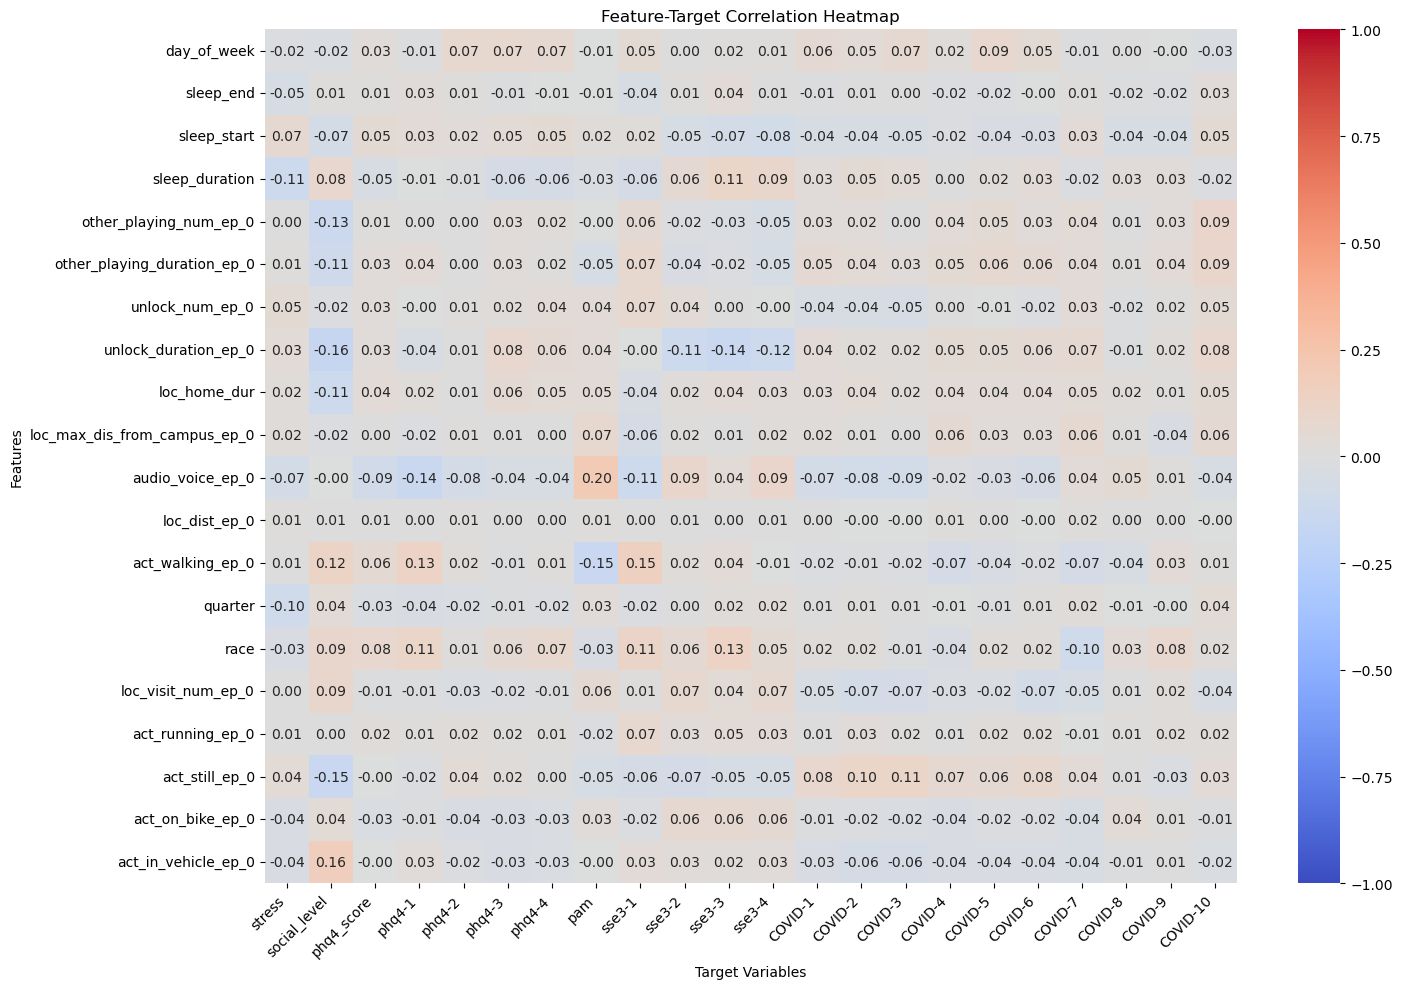


Significant correlations (p < 0.05):
--------------------------------------------------
day_of_week → stress:
  Correlation: r = -0.022 (p = 4.985e-03)
day_of_week → social_level:
  Correlation: r = -0.024 (p = 2.353e-03)
day_of_week → phq4_score:
  Correlation: r = 0.030 (p = 9.488e-05)
day_of_week → phq4-2:
  Correlation: r = 0.071 (p = 7.069e-20)
day_of_week → phq4-3:
  Correlation: r = 0.071 (p = 1.015e-19)
day_of_week → phq4-4:
  Correlation: r = 0.066 (p = 4.254e-17)
day_of_week → sse3-1:
  Correlation: r = 0.051 (p = 6.204e-11)
day_of_week → COVID-1:
  Correlation: r = 0.058 (p = 8.394e-14)
day_of_week → COVID-2:
  Correlation: r = 0.046 (p = 5.009e-09)
day_of_week → COVID-3:
  Correlation: r = 0.065 (p = 6.023e-17)
day_of_week → COVID-4:
  Correlation: r = 0.016 (p = 4.152e-02)
day_of_week → COVID-5:
  Correlation: r = 0.085 (p = 5.803e-28)
day_of_week → COVID-6:
  Correlation: r = 0.050 (p = 1.068e-10)
day_of_week → COVID-10:
  Correlation: r = -0.029 (p = 1.647e-04)
sleep_en

In [88]:
def analyze_correlations(data, importance_df):
    """
    Analyze Pearson correlations between top 20 important features and all target columns
    """
    # Get top 20 features from importance_df
    features = importance_df.head(20)['feature'].tolist()
    
    # Define all target columns
    target_cols = [
        'stress', 'social_level', 'phq4_score', 
        'phq4-1', 'phq4-2', 'phq4-3', 'phq4-4',
        'pam', 'sse3-1', 'sse3-2', 'sse3-3', 'sse3-4',
        'COVID-1', 'COVID-2', 'COVID-3', 'COVID-4', 'COVID-5', 
        'COVID-6', 'COVID-7', 'COVID-8', 'COVID-9', 'COVID-10'
    ]
    
    # Create a copy of the data we'll use
    analysis_data = data.copy()
    
    # Encode categorical variables
    from sklearn.preprocessing import LabelEncoder
    categorical_features = ['day_of_week', 'race']
    
    for feature in categorical_features:
        if feature in features:  # Only encode if it's in our selected features
            le = LabelEncoder()
            analysis_data[feature] = le.fit_transform(analysis_data[feature].astype(str))
    
    try:
        # Calculate correlations
        correlations = np.zeros((len(features), len(target_cols)))
        p_values = np.zeros((len(features), len(target_cols)))
        
        for i, feature in enumerate(features):
            for j, target in enumerate(target_cols):
                try:
                    stat, p_val = stats.pearsonr(
                        analysis_data[feature].fillna(analysis_data[feature].median()),
                        analysis_data[target].fillna(analysis_data[target].median())
                    )
                    correlations[i, j] = stat
                    p_values[i, j] = p_val
                except Exception as e:
                    print(f"Warning: Could not calculate correlation for {feature} → {target}: {str(e)}")
                    correlations[i, j] = np.nan
                    p_values[i, j] = np.nan
        
        # Create correlation DataFrame
        corr_df = pd.DataFrame(correlations, index=features, columns=target_cols)
        
        # Plot heatmap
        plt.figure(figsize=(15, 10))
        sns.heatmap(corr_df,
                   annot=True,
                   cmap='coolwarm',
                   vmin=-1, vmax=1,
                   center=0,
                   fmt='.2f')
        plt.title('Feature-Target Correlation Heatmap')
        plt.xlabel('Target Variables')
        plt.ylabel('Features')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Print significant correlations
        print("\nSignificant correlations (p < 0.05):")
        print("-" * 50)
        for i, feature in enumerate(features):
            for j, target in enumerate(target_cols):
                if not np.isnan(p_values[i, j]) and p_values[i, j] < 0.05:
                    corr = correlations[i, j]
                    p_val = p_values[i, j]
                    print(f"{feature} → {target}:")
                    print(f"  Correlation: r = {corr:.3f} (p = {p_val:.3e})")
    
    except Exception as e:
        print(f"Error in correlation analysis: {str(e)}")
        import traceback
        traceback.print_exc()

# Run the analysis
analyze_correlations(merged_data, feature_ranking)

# Select Features with RFE??

In [80]:
def select_features_with_rfe(data, target_col, feature_dict, n_features_to_select=20):
    """
    Use RFE with DecisionTreeClassifier to select the best features, excluding EMA features
    """
    # Create a copy of the data
    data = data.copy()
    
    # Get allowed features from feature_dict (excluding EMA)
    allowed_features = []
    
    allowed_features.extend(feature_dict['date'])
    allowed_features.extend(feature_dict['demographics'])
    for platform in feature_dict['activity']:
        allowed_features.extend(feature_dict['activity'][platform])
    allowed_features.extend(feature_dict['location'])
    for platform in feature_dict['phone']:
        allowed_features.extend(feature_dict['phone'][platform])
    for platform in feature_dict['sleep']:
        allowed_features.extend(feature_dict['sleep'][platform])
    if 'audio' in feature_dict:
        for platform in feature_dict['audio']:
            allowed_features.extend(feature_dict['audio'][platform])
    if 'calls' in feature_dict:
        for platform in feature_dict['calls']:
            allowed_features.extend(feature_dict['calls'][platform])
    print(f"\nTotal allowed features: {len(allowed_features)}")
    
    # Filter data to only include allowed features plus target
    features_to_use = [col for col in allowed_features if col in data.columns]
    features_to_use.append(target_col)
    
    data = data[features_to_use]
    
    # Remove rows where target variable is NaN
    data = data.dropna(subset=[target_col])
    print(f"\nRemoved rows where {target_col} is NaN")
    
    # Remove columns with too many NaN values (>50%)
    threshold = len(data) * 0.5
    columns_to_keep = [col for col in data.columns if col != target_col 
                      and data[col].isnull().sum() < threshold]
    
    print(f"\nRemoved {len(features_to_use) - len(columns_to_keep) - 1} columns with >50% NaN values")
    
    # Rest of your existing RFE code...
    X = data[columns_to_keep].copy()
    y = data[target_col].copy()
    
    # Fill NaN values
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    
    # Handle NaN values using .loc
    for col in numeric_cols:
        X.loc[:, col] = X[col].fillna(X[col].median())
    
    for col in categorical_cols:
        X.loc[:, col] = X[col].fillna(X[col].mode().iloc[0])
        X.loc[:, col] = LabelEncoder().fit_transform(X[col])
    
    print(f"\nFinal dataset shape: {X.shape}")
    print(f"Numeric features: {len(numeric_cols)}")
    print(f"Categorical features: {len(categorical_cols)}")
    # Initialize and fit RFE
    dt = DecisionTreeClassifier(random_state=42)
    rfe = RFE(estimator=dt, 
                n_features_to_select=n_features_to_select,
                step=0.1)
    rfe.fit(X, y)
    
    # Get results
    feature_ranking = pd.DataFrame({
        'feature': columns_to_keep,
        'rank': rfe.ranking_,
        'selected': rfe.support_
    }).sort_values('rank')
    
    selected_features = feature_ranking[feature_ranking['selected']]['feature'].tolist()
    
    # Print results
    print(f"\nTop {n_features_to_select} features selected by RFE:")
    print("-" * 50)
    for i, feature in enumerate(selected_features, 1):
        feature_type = "categorical" if feature in categorical_cols else "numeric"
        print(f"{i}. {feature} ({feature_type})")
        
    return selected_features, feature_ranking


# Run feature selection with feature dictionary
selected_features, feature_ranking = select_features_with_rfe(
    merged_data, 
    'stress',
    feature_dict,
    n_features_to_select=20
)


Total allowed features: 42

Removed rows where stress is NaN

Removed 9 columns with >50% NaN values

Final dataset shape: (12771, 32)
Numeric features: 29
Categorical features: 3


/var/folders/q7/wb0b9dm92v17lzlzks_c98mc0000gp/T/ipykernel_12530/4025047303.py:59: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, col] = LabelEncoder().fit_transform(X[col])
/var/folders/q7/wb0b9dm92v17lzlzks_c98mc0000gp/T/ipykernel_12530/4025047303.py:59: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, col] = LabelEncoder().fit_transform(X[col])
/var/folders/q7/wb0b9dm92v17lzlzks_c98mc0000gp/T/ipykernel_12530/4025047303.py:59: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values i


Top 20 features selected by RFE:
--------------------------------------------------
1. day_of_week (categorical)
2. sleep_end (numeric)
3. sleep_start (numeric)
4. sleep_duration (numeric)
5. other_playing_num_ep_0 (numeric)
6. other_playing_duration_ep_0 (numeric)
7. unlock_num_ep_0 (numeric)
8. unlock_duration_ep_0 (numeric)
9. loc_home_dur (numeric)
10. loc_max_dis_from_campus_ep_0 (numeric)
11. audio_voice_ep_0 (numeric)
12. loc_dist_ep_0 (numeric)
13. act_walking_ep_0 (numeric)
14. quarter (numeric)
15. race (categorical)
16. loc_visit_num_ep_0 (numeric)
17. act_running_ep_0 (numeric)
18. act_still_ep_0 (numeric)
19. act_on_bike_ep_0 (numeric)
20. act_in_vehicle_ep_0 (numeric)
